In [2]:
# cargamos las librerias necesarias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from joblib import load
from sklearn.preprocessing import StandardScaler

/var/folders/82/981937551rd3qhsg1c05yn4c0000gn/T/ipykernel_2067/1516922532.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# creamos función para cargar modelo Adaboost
def load_model():
    model = load('../Modelos/best_adaboost.pkl')
    return model



## **_1. Lectura (carga) de los Datos_**

In [4]:
# importamos archivo de datos sin normalizar para los análisis 
df = pd.read_csv('../Data/df_final_pay_sin_mt.csv', decimal='.')

In [5]:
df.head()

,year_2023,year_2024,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,CAT 798-AC,KOM-CHQ,KOM.960E5,Kom.930E-4,Kom.930E-4SE,Kom.930EN,Kom.930ER,Kom.930ER-MT,Kom.980E5,Komatsu AHS
0,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,395.0,96.0,240.0,0.0,132.0,24.0
1,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,396.0,96.0,240.0,0.0,132.0,24.0
2,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,394.0,96.0,240.0,0.0,132.0,24.0
3,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,95.0,396.0,96.0,240.0,0.0,132.0,24.0
4,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,395.0,96.0,240.0,0.0,132.0,24.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 86 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   year_2023            1567 non-null   category
 1   year_2024            1567 non-null   category
 2   month_2              1567 non-null   category
 3   month_3              1567 non-null   category
 4   month_4              1567 non-null   category
 5   month_5              1567 non-null   category
 6   month_6              1567 non-null   category
 7   month_7              1567 non-null   category
 8   month_8              1567 non-null   category
 9   month_9              1567 non-null   category
 10  month_10             1567 non-null   category
 11  month_11             1567 non-null   category
 12  month_12             1567 non-null   category
 13  day_2                1567 non-null   category
 14  day_3                1567 non-null   category
 15  day_4                

In [7]:
# generamos columna de validación de payload mean
df['payload_validation'] = np.where(df['payload'] >= df.payload.mean(), 
                                        np.int8(1), np.int8(0))

In [8]:
df.payload_validation.value_counts()

payload_validation
0    825
1    742
Name: count, dtype: int64

In [9]:
# calculamos la disponibilidad de los camiones
df['truck_avail'] = (df.total - (df.mantencion + df.mecanica + df.electrica + df.mant_excl + df.mec_excl + df.elec_excl + df.som_excl)) / df.total

In [10]:
df.truck_avail.describe()

count    1567.000000
mean        0.757987
std         0.039612
min         0.622591
25%         0.733914
50%         0.761742
75%         0.786180
max         0.901208
Name: truck_avail, dtype: float64

In [11]:
# separamos las mecánicas 
mecanicas_up = df[df['payload_validation']==1][['mantencion', 'mecanica', 'electrica', 'mant_excl', 'mec_excl', 'elec_excl', 'som_excl']]
mecanicas_down = df[df['payload_validation']==1][['mantencion', 'mecanica', 'electrica', 'mant_excl', 'mec_excl', 'elec_excl', 'som_excl']]
total_up = df[df['payload_validation']==1]['total'].sum()
total_down = df[df['payload_validation']==0]['total'].sum()

## **2. Preparamos el Dataset**

In [12]:
# transformamos las variables bool a categorical y le asignamos 0 o 1
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].apply(lambda x: x.astype('category').cat.codes).astype('category')

In [14]:
# definimos el dataframe numérico
df_numeric = df.select_dtypes(include=['float64', 'int64'])

In [17]:
# creamos dataframe con los valores de media y desviación estándar
df_estadisticas = pd.DataFrame({'mean': df_numeric.mean(), 'std': df_numeric.std()}).T
df_estadisticas

,total,efectivo,mantencion,mecanica,electrica,mant_excl,mec_excl,elec_excl,som_excl,demora,...,KOM-CHQ,KOM.960E5,Kom.930E-4,Kom.930E-4SE,Kom.930EN,Kom.930ER,Kom.930ER-MT,Kom.980E5,Komatsu AHS,truck_avail
mean,4.437531e+06,2.909883e+06,214850.865348,483912.316528,23898.837907,55319.616465,151162.946394,10843.929802,134217.326739,106212.267390,...,8.954052,3.742821,95.901723,382.012125,56.431398,239.878111,0.005105,142.752393,26.330568,0.757987
std,7.818236e+04,1.845828e+05,68190.461647,144272.025432,24307.483783,34690.638029,91140.845874,16501.509489,88123.500844,74487.204515,...,15.562191,7.406866,0.513462,23.049267,17.377787,1.198583,0.142857,3.607316,22.947783,0.039612


In [18]:
# guardamos el archivo con las estadísticas
df_estadisticas.to_csv('../Data/df_estadisticas.csv')

In [11]:
# guardamos la media y la desviación estándar de las variables numéricas
df_estadisticas_up = pd.DataFrame()
df_estadisticas_down = pd.DataFrame()

df_estadisticas_up = df_numeric[df.payload_validation == 1].agg(['mean', 'std'])
df_estadisticas_down = df_numeric[df.payload_validation == 0].agg(['mean', 'std'])

# cambiamos el nombre de las filas
df_estadisticas_up = df_estadisticas_up.rename(index={0: 'mean', 1: 'std'})
df_estadisticas_down = df_estadisticas_down.rename(index={0: 'mean', 1: 'std'})

# guardamos el archivo con las estadísticas
df_estadisticas_up.to_csv('../Data/df_estadisticas_up.csv')
df_estadisticas_down.to_csv('../Data/df_estadisticas_down.csv')

In [12]:
# estandarizamos las variables numéricas
col_num = df.drop(columns=['payload','truck_avail','payload_validation'], axis=1).select_dtypes(include=['float64','int64']).columns

scaler = StandardScaler()
df[col_num] = scaler.fit_transform(df[col_num])

In [13]:
len(df.columns)

86

In [14]:
# seleccionamos las variables que vamos a usar
df_selected = df[['payload', 'year_2023', 'year_2024', 'month_3', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6', 'day_10', 'day_11', 'day_13', 'day_15', 'day_16',
       'day_17', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25',
       'day_26', 'day_27', 'day_28', 'day_30', 'day_31', 'shift_B', 'crew_E2',
       'crew_E3', 'crew_E4', 'efectivo', 'mantencion', 'mecanica', 'electrica',
       'mant_excl', 'mec_excl', 'demora', 'r_noprg', 'waiting', 'queued',
       'distance_down_level', 'distance_up', 'distance_up_level',
       'expected_time', 'lift_down', 'lift_down_level', 'lift_up',
       'lift_up_level', 'travel_time', 'CAT 797-F', 'CAT 798-AC', 'KOM-CHQ',
       'KOM.960E5', 'Kom.930E-4', 'Kom.930E-4SE', 'Kom.930ER-MT', 'Kom.980E5',
       'Komatsu AHS', 'truck_avail', 'payload_validation']].copy()

In [15]:
len(df_selected.columns)

67

In [16]:
df_selected.shape

(1567, 67)

In [17]:
df_selected.payload.mean()

142357.4639507874

In [18]:
# generamos dataframe de características con payload_validation = 1 (sobre la media)
df_caracteristicas_up = df_selected[df_selected.payload_validation == 1].drop(columns=['payload', 
                                                                                       'payload_validation',
                                                                                       'truck_avail'], axis=1).copy()
df_caracteristicas_up = df_caracteristicas_up.reset_index(drop=True)
df_caracteristicas_up.shape

(742, 64)

In [19]:
# guardamos columnas de comparación up
df_com_up = df_selected[df_selected.payload_validation == 1].copy()
df_com_up = df_com_up.reset_index(drop=True)
df_com_up.shape

(742, 67)

In [20]:
# guardamos el archivo de columnas de comparación up
df_com_up.to_csv('../Data/df_com_up_var1.csv', index=False)

In [21]:
# generamos dataframe de características con payload_validation = 0 (bajo la media)
df_caracteristicas_down = df_selected[df_selected.payload_validation == 0].drop(columns=['payload', 
                                                                                         'payload_validation',
                                                                                         'truck_avail'], axis=1).copy()
df_caracteristicas_down = df_caracteristicas_down.reset_index(drop=True)
df_caracteristicas_down.shape

(825, 64)

In [22]:
# guardamos columnas de comparación down
df_com_down = df_selected[df_selected.payload_validation == 0].copy()
df_com_down = df_com_down.reset_index(drop=True)
df_com_down.shape

(825, 67)

In [23]:
# guardamos el archivo de columnas de comparación down
df_com_down.to_csv('../Data/df_com_down_var1.csv', index=False)

## **3. Análisis Exploratorio de Datos (EDA)**

### **3.1. Distance Up Level**

#### **3.1.1. Análisis de la Variable**

Saving figure relacion_distance_up_level_payload


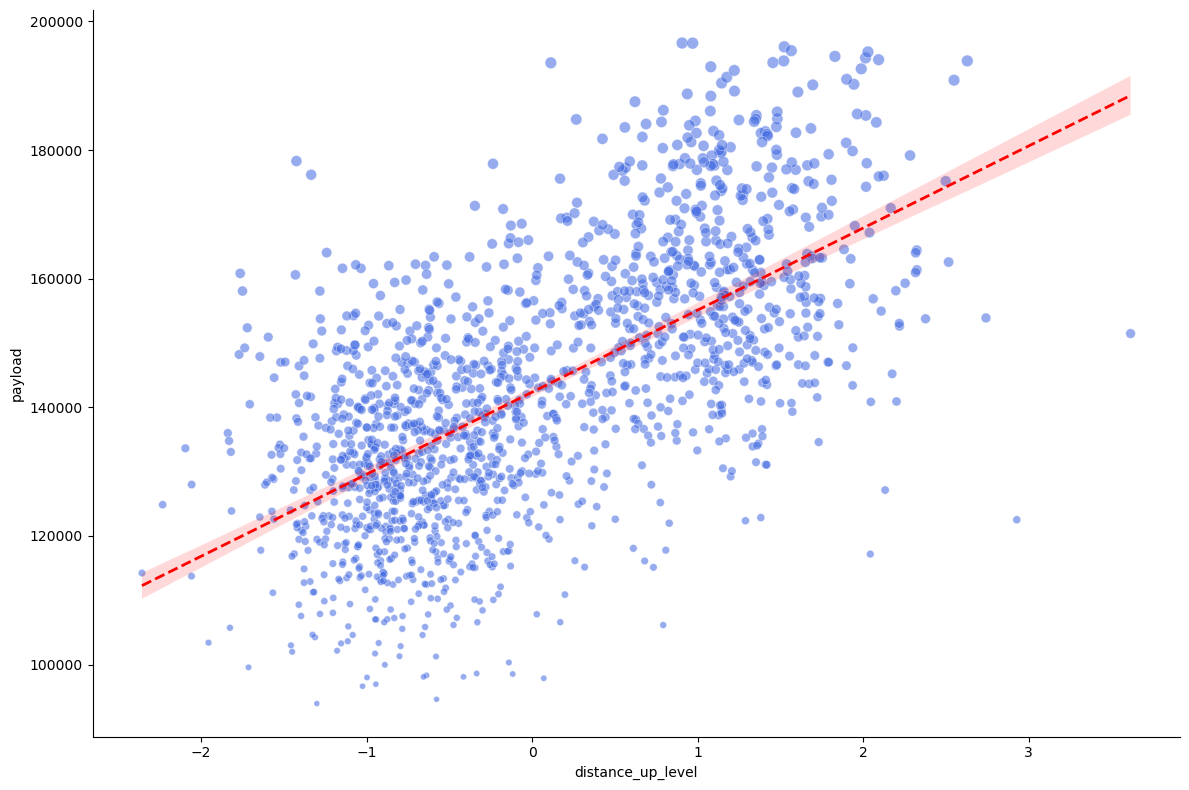

In [57]:
# relación entre distance_up_level y payload
plt.figure(figsize=(10, 6))

# definimos una paleta de colores
custom_palette = {0: 'slategray', 1: 'tomato'}

sns.scatterplot(x='distance_up_level',  
                y='payload',
                data=df, 
                #hue='payload_validation',
                #style='payload_validation',
                size='payload',
                markers=['o', 'h'],
                legend= False,
                alpha=0.55,
                #linewidth=0.3,
                #edgecolor='darkgrey',
                #palette = custom_palette,
                color='royalblue'
                )

# línea de tendencia (regplot)
sns.regplot(x='distance_up_level',  
            y='payload',
            data=df, 
            scatter=False,  # No muestra los puntos
            color='red', 
            line_kws={"linewidth":2, "linestyle":"--"})  # Estilo de la línea

# mejoramos la visualización
sns.despine()

In [52]:
# guardamos la imagen en alta resolución
save_fig('relacion_distance_up_level_payload')

Saving figure relacion_distance_up_level_payload


<Figure size 640x480 with 0 Axes>

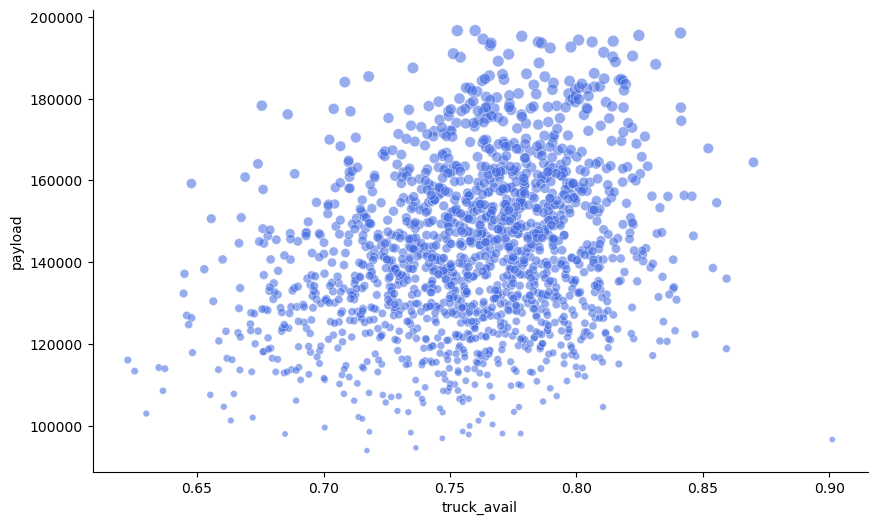

In [25]:
# relación entre distance_up_level y payload
plt.figure(figsize=(10, 6))

# definimos una paleta de colores
custom_palette = {0: 'slategray', 1: 'tomato'}

sns.scatterplot(x='truck_avail',  
                y='payload',
                data=df, 
                #hue='payload_validation',
                #style='payload_validation',
                size='payload',
                markers=['o', 'h'],
                legend= False,
                alpha=0.55,
                #linewidth=0.3,
                #edgecolor='darkgrey',
                #palette = custom_palette,
                color='royalblue'
                )

# mejoramos la visualización
sns.despine()

Saving figure relacion_distance_up_level_truck_avail


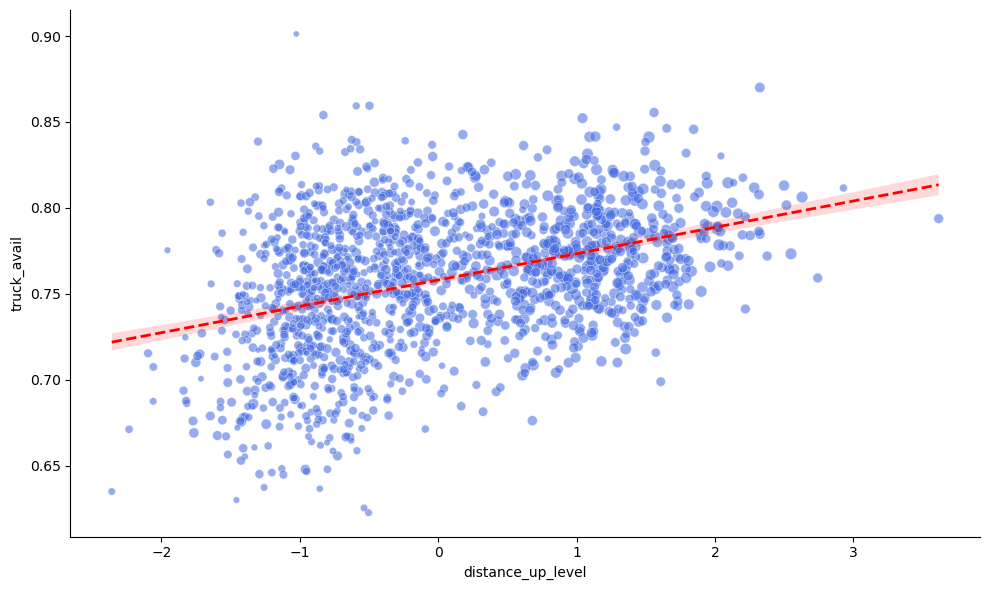

In [53]:
# relación entre distance_up_level y truck_avail
plt.figure(figsize=(10, 6))
# definimos una paleta de colores
custom_palette = {0: 'slategray', 1: 'tomato'}
sns.scatterplot(x='distance_up_level',
                y='truck_avail', 
                data=df, 
                #hue='payload_validation', 
                #style='payload_validation',
                size='payload',
                markers=['o', 's'],
                legend= False,
                alpha=0.55,
                #linewidth=0.3,
                #edgecolor='darkgrey',
                #palette = custom_palette,
                color='royalblue'
                )

# línea de tendencia (regplot)
sns.regplot(x='distance_up_level',  
            y='truck_avail',
            data=df, 
            scatter=False,  # No muestra los puntos
            color='red', 
            line_kws={"linewidth":2, "linestyle":"--"})  # Estilo de la línea

# mejoramos la visualización
sns.despine()

In [27]:
import plotly.graph_objects as go
import numpy as np

# Datos de ejemplo
x = df.truck_avail
y = df.distance_up_level
z = df.payload

# Crear gráfico de dispersión 3D
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(size=7, 
                color='royalblue', 
                opacity=0.5, 
                #line=dict(color='blue', width=0.01)
                )
)])

# Personalizar el eje X
fig.update_layout(
    scene=dict(
        xaxis=dict(
            title='truck_avail',  # Título del eje X
            titlefont=dict(size=18, color='rgba(62, 62, 62, 0.8)'),  # Fuente del título
            tickfont=dict(size=14, color='rgba(62, 62, 62, 0.8)'),  # Fuente de las etiquetas
            gridcolor='rgba(62, 62, 62, 0.2)',  # Color de las líneas de la cuadrícula
            zerolinecolor='rgba(62, 62, 62, 0.5)',  # Color de la línea en cero
            showgrid=True,  # Mostrar cuadrícula
            showline=True,  # Mostrar línea del eje
            showticklabels=True,  # Mostrar etiquetas
            linecolor='rgba(62, 62, 62, 0.8)',  # Color de la línea del eje
            ticks='outside',  # Posición de las marcas
            backgroundcolor='rgba(50, 50, 50, 0.5)'  # Fondo más oscuro para ejes
        ),
        yaxis=dict(
            title='distance_up_level',
            titlefont=dict(size=18, color='rgba(62, 62, 62, 0.8)'),
            tickfont=dict(size=14, color='rgba(62, 62, 62, 0.8)'),
            gridcolor='rgba(62, 62, 62, 0.2)',
            zerolinecolor='rgba(62, 62, 62, 0.5)',
            showgrid=True,
            showline=True,
            showticklabels=True,
            linecolor='rgba(62, 62, 62, 0.8)',
            ticks='outside',
            backgroundcolor='rgba(50, 50, 50, 0.5)'
        ),
        zaxis=dict(
            title='payload',
            titlefont=dict(size=18, color='rgba(62, 62, 62, 0.8)'),
            tickfont=dict(size=14, color='rgba(62, 62, 62, 0.8)'),
            gridcolor='rgba(62, 62, 62, 0.2)',
            zerolinecolor='rgba(62, 62, 62, 0.5)',
            showgrid=True,
            showline=True,
            showticklabels=True,
            linecolor='rgba(62, 62, 62, 1)',
            ticks='outside',
            backgroundcolor='rgba(50, 50, 50, 0.5)'
            
            )
    ),
    title='Gráfico de Dispersión 3D Interactivo',
    width=1000,
    height=1000,
    margin=dict(l=0, r=0, b=100, t=50),
    paper_bgcolor='rgba(255, 255, 255, 1)',
    plot_bgcolor='rgba(10, 10, 10, 1)'
)

# Mostrar el gráfico
fig.show()


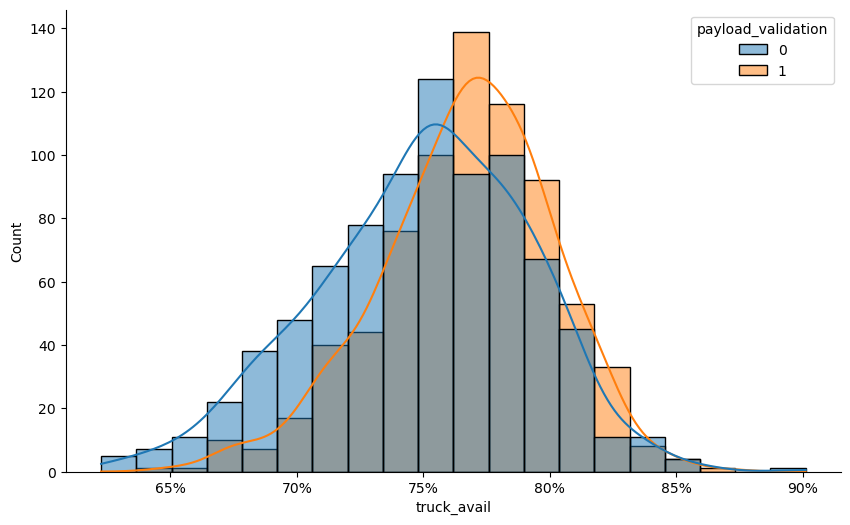

In [28]:
# generamos un grafico de frecuencia de la variable truck_avail
plt.figure(figsize=(10, 6))
sns.histplot(data=df,
             x='truck_avail', 
             bins=20, 
             color='royalblue', 
             kde=True,
             hue='payload_validation')
             
# damos formato de porcentaje al eje x
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

# mejoramos la visualización
sns.despine()
plt.show()

/var/folders/82/981937551rd3qhsg1c05yn4c0000gn/T/ipykernel_2560/2486831836.py:4: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/var/folders/82/981937551rd3qhsg1c05yn4c0000gn/T/ipykernel_2560/2486831836.py:8: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



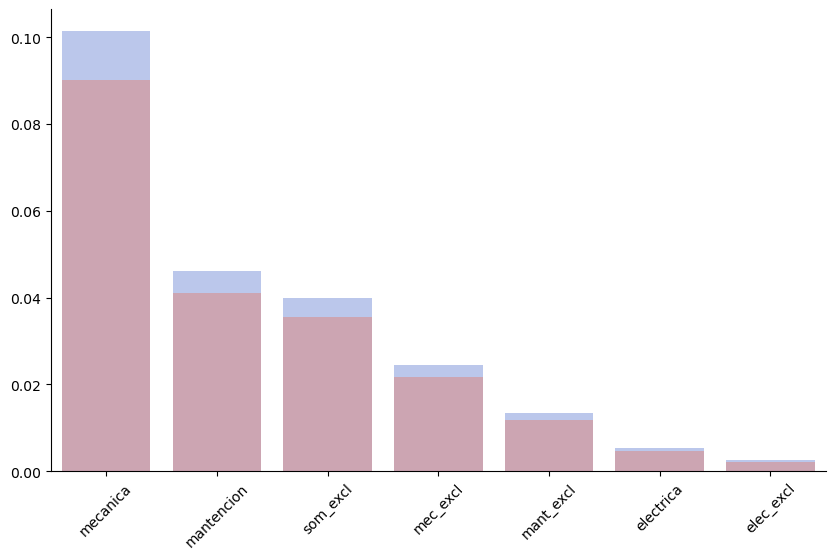

In [59]:
# generamos un gráfico de barras con las mecánicas
plt.figure(figsize=(10, 6))

sns.barplot((mecanicas_up.groupby(mecanicas_up.columns, axis=1).sum().sum() / total_up).sort_values(ascending=False),
            alpha=0.4,
            color='royalblue', 
            label='mecanicas up')
sns.barplot((mecanicas_down.groupby(mecanicas_down.columns, axis=1).sum().sum() / total_down).sort_values(ascending=False),
            alpha=0.4,
           color='tomato',
           label='mecanicas down')



# mejoramos la visualización
sns.despine()
plt.tick_params(axis='x', rotation=45)
plt.show()


#### **3.1.2. Evaluación de las características con la nueva variable en el modelo**

In [30]:
# generamos vector con las distancias por sobre la media
distance_up = pd.DataFrame(df_selected[df_selected.payload_validation == 1].distance_up_level, 
                           columns=['distance_up_level']) 
distance_up.shape

(742, 1)

In [31]:
# generamos dataframe con características objetivo
df_caract_obj = df_caracteristicas_down.drop(columns=['distance_up_level'], axis=1)
df_caract_obj.shape

(825, 63)

In [32]:
# cargamos el modelo
best_adaboost = load_model()

In [33]:
# Precalculamos la media del payload para evitar recalcularla en cada iteración
payload_mean = df_selected.payload.mean()

# Lista para almacenar los resultados
results = []

features_start_all = df_caract_obj.iloc[:, :48].values
features_end_all = df_caract_obj.iloc[:, 48:].values

for i in range(df_caract_obj.shape[0]):
    features_start = features_start_all[i]
    features_end = features_end_all[i]
    
    # Repetimos las características para coincidir con el tamaño de distance_up
    features_start_repeated = pd.DataFrame([features_start]*distance_up.shape[0], columns=df_caract_obj.columns[:48])
    features_end_repeated = pd.DataFrame([features_end]*distance_up.shape[0], columns=df_caract_obj.columns[48:])
    
    # Combinamos las características con distance_up
    caract_eval = pd.concat([
        features_start_repeated.reset_index(drop=True),
        distance_up.reset_index(drop=True),
        features_end_repeated.reset_index(drop=True)
    ], axis=1)
    
    # Evaluamos el modelo de forma vectorizada
    predictions = best_adaboost.predict(caract_eval)
    
    ### --- Preparamos los filtros para seleccionar sólo aquellos que cumplen con la condición --- ###
    # Calcula las diferencias donde las predicciones son mayores o iguales al promedio
    differences = predictions - payload_mean
    # Filtra las diferencias no negativas
    non_negative_differences = differences[differences >= 0]
    
    if non_negative_differences.size != 0:
        # Encuentra la diferencia mínima no negativa
        min_difference = np.min(non_negative_differences)

        # Encuentra los índices válidos
        valid_indices = np.where((predictions >= payload_mean) & (differences == min_difference))[0]

        # Si existen índices válidos, tomamos el primero
        indice_j = valid_indices[0]
        pred_j = predictions[indice_j]
        cumple = 'cumple'
    else:
        # Si no, tomamos el último índice
        indice_j = distance_up.shape[0] - 1
        pred_j = predictions[indice_j]
        cumple = 'no_cumple'
    
    # Construimos el vector de resultado
    vec_resultado = np.concatenate([
        [pred_j],
        features_start,
        distance_up.iloc[indice_j].values,
        features_end,
        [cumple]
    ])
    
    # Agregamos el vector a la lista de resultados
    results.append(vec_resultado)

# Convertimos la lista de resultados en un DataFrame
df_resultado = pd.DataFrame(results, columns=['prediction'] + list(df_caract_obj.columns[:48]) + list(distance_up.columns) + list(df_caract_obj.columns[48:]) + ['status'])


In [34]:
df_resultado.status.value_counts()

status
cumple       512
no_cumple    313
Name: count, dtype: int64

In [35]:
# guardamos el dataframe en un archivo csv
df_resultado.to_csv('../Data/df_resultado_var1(vec).csv', index=False)

In [36]:
# guardamos los requerimientos del ambiente
import os
os.system('pip freeze > ../requirements_py312.txt')

0